In [294]:
# Exercise 1 
# Parisa Amanibeni [iq81ywef]
# Rathi Pankaj Mukeshbhai [or90amew]

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import random
import math
from scipy import ndimage

# Load the .mat file
data = loadmat('data/example2kinect.mat')

FileNotFoundError: [Errno 2] No such file or directory: 'data/example2kinect.mat'

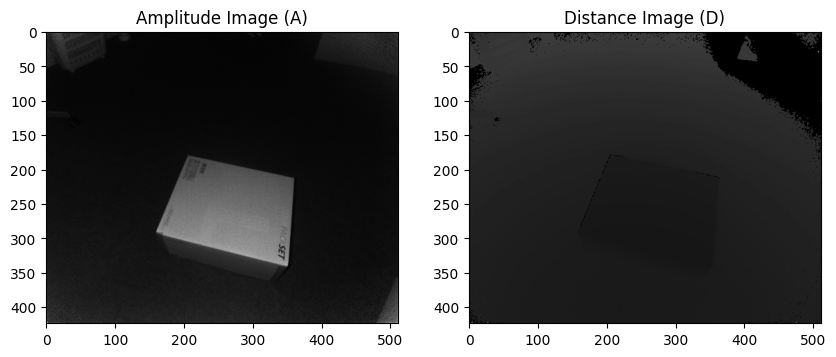

In [246]:
# Access A, D, and PC
A = data['amplitudes2']
D = data['distances2']
PC = data['cloud2']

# Visualize A and D as 2D images
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(A, cmap='gray')
plt.title('Amplitude Image (A)')
plt.subplot(1, 2, 2)
plt.imshow(D, cmap='gray')
plt.title('Distance Image (D)')
plt.show()



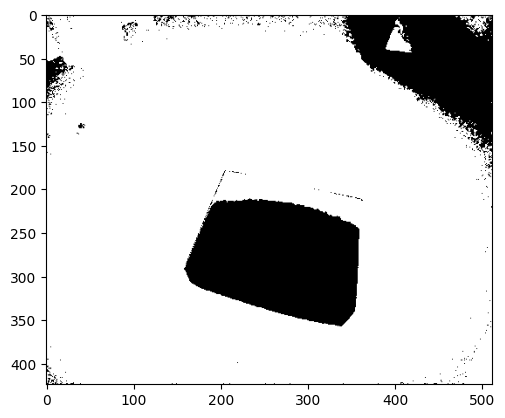

In [253]:
# Load the 2D distance image
distance_image = D
# Set your chosen threshold value
#threshold_value = 0.76  # Adjust this value as needed
threshold_value = 1  # Adjust this value as needed
# Apply thresholding to create a binary mask
ret, binary_mask = cv2.threshold(distance_image, threshold_value, 1, cv2.THRESH_BINARY)
# Optionally, invert the binary mask if the box is represented by white pixels
#binary_mask = 1 - binary_mask
# You now have a binary mask that separates the box from the background.
plt.imshow(binary_mask, cmap='gray')
plt.show()

NameError: name 'PC' is not defined

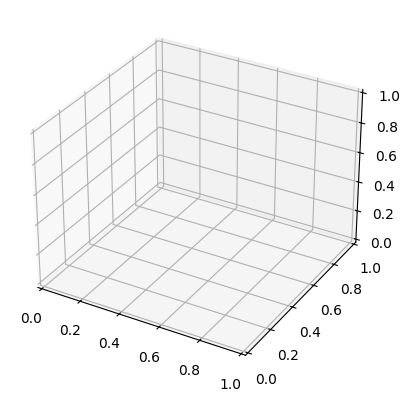

In [3]:
# Visualize PC as a 3D point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y, z = PC[:, :, 0], PC[:, :, 1], PC[:, :, 2]
ax.scatter(x, y, z, c=z, cmap='viridis', marker='.')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Point Cloud (PC)')
plt.show()


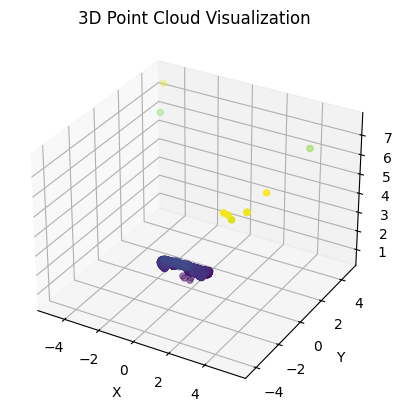

In [255]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Removing the points with z=0 from the point cloud
indices = np.transpose(np.nonzero(PC[:, :, 2]))
NonZero_point_cloud = PC[indices[:, 0], indices[:, 1]]

# Extract x, y, and z components from selected_points
x_values = NonZero_point_cloud[:, 0]
y_values = NonZero_point_cloud[:, 1]
z_values = NonZero_point_cloud[:, 2]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the selected points
ax.scatter(x_values, y_values, z_values, c=z_values, marker='o')

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.title('3D Point Cloud Visualization')
plt.show()


surface Detection

In [256]:
def floor_detection(point_cloud, threshold, max_iterations):
    print('****** floor detection function ******')
    floor_eq = []
    mask_floor = None
    
    floor_eq , mask_floor = ransac(point_cloud, threshold, max_iterations)
    print('****** RANSAC algorithm finished! ******')
    
    return floor_eq, mask_floor

def ransac(point_cloud, threshold, max_iterations):
    print('****** RANSAC algorithm get started ... ******')

    best_eq = []
    best_mask_floor_points = None
    best_num_inliers = 0

    # remove the points with Z=0
    indices = np.transpose(np.nonzero(point_cloud[:, :, 2]))
    NonZero_point_cloud = point_cloud[indices[:, 0], indices[:, 1]]
    print('points with z=0 removed')

    # Create a boolean mask to identify valid points (z-component is not zero)
    # each element will be `True` if the corresponding point's z-component is not zero.
    # Shape [i,j]
    mask_None_zero_points = point_cloud[:, :, 2] != 0

    print('****** start iterations ******')
    for iteration in range(max_iterations):
        
        # select 3 random points from the None zero points
        random_points = random.sample(NonZero_point_cloud.tolist(), 3)
        pt_samples = np.array(random_points)
        # Fit a plane model to the sampled points
        plane_eq = fit_plane(pt_samples)

        #inliers calculation
        num_inliers, mask_floor_points = calculate_inliers(point_cloud, plane_eq, threshold, mask_None_zero_points)

        # If this model has more inliers, update the best model
        if (num_inliers > best_num_inliers):
            best_num_inliers = num_inliers
            best_mask_floor_points = mask_floor_points
            best_eq = plane_eq

    return best_eq, best_mask_floor_points

def fit_plane( pt_samples ):
    vecA = pt_samples[1, :] - pt_samples[0, :]
    vecB = pt_samples[2, :] - pt_samples[0, :]
    vecC = np.cross(vecA, vecB)
    vecC = vecC / np.linalg.norm(vecC) # Normalize vecC
    k = -np.sum(np.multiply(vecC, pt_samples[1, :]))
    # Ax+By+Cz+D = 0
    plane_eq = [vecC[0], vecC[1], vecC[2], k]
    return plane_eq

def calculate_inliers(point_cloud, plane_eq, threshold, mask_None_zero_points):
    #Shape [i,j]
    distances = point_to_plane_distance(point_cloud, plane_eq )
    
    # Create a boolean mask to select points below the threshold
    # shape [i,j]
    mask_distance_threshold = distances <= threshold 
    mask_floor_points = mask_None_zero_points & mask_distance_threshold

    inliers = point_cloud[mask_floor_points]
    num_inliers = len(inliers)

    return num_inliers, mask_floor_points

def point_to_plane_distance(point_cloud, plane_eq):
    A, B, C, D = plane_eq
    distances = np.abs((A * point_cloud[:, :, 0] + B * point_cloud[:, :, 1] + C * point_cloud[:, :, 2] + D) / np.sqrt(A**2 + B**2 + C**2))
    return distances

In [257]:
floor_eq, mask_floor = floor_detection(PC, 0.05, 100)
# keep the distances only for the points specified by the mask, and set distances to 0 for points not satisfying the mask

****** floor detection function ******
****** RANSAC algorithm get started ... ******
points with z=0 removed
****** start iterations ******
****** RANSAC algorithm finished! ******


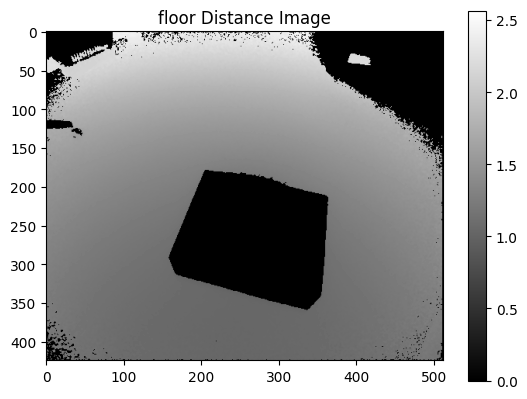

In [258]:
filtered_D = np.where(mask_floor, D, 0)
plt.imshow(filtered_D, cmap='gray')
plt.colorbar()  # Add a colorbar to the plot
plt.title("floor Distance Image")
plt.show()

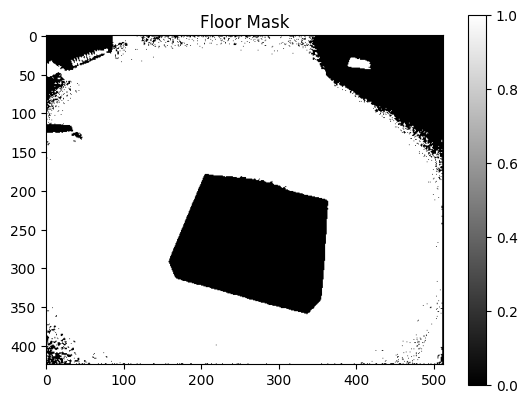

In [259]:
# Set threshold value to extract the floor Mask (floor = 1 , other = 0 )
threshold_value = 0.73  # Adjust this value as needed

# Apply thresholding to create a binary mask
ret, mask_binary_floor_0_1 = cv2.threshold(filtered_D, threshold_value, 1, cv2.THRESH_BINARY)
# You now have a binary mask that separates the box from the background.
plt.imshow(mask_binary_floor_0_1, cmap='gray')
plt.colorbar()  # Add a colorbar to the plot
plt.title("Floor Mask")
plt.show()

In [260]:
#morphological_filter
def morphological_filter(mask_binary_floor_0_1, kernel, operation):
    filter_type = None
    if operation == 'opening':
        # Opening: Erosion followed by dilation. Useful for removing noise and small objects.
        mask_morphological_filtered_floor_0_1 = cv2.morphologyEx(mask_binary_floor_0_1, cv2.MORPH_OPEN, kernel)
        filter_type = 'Opening filter'
    elif operation == 'closing':
        # Closing: Dilation followed by erosion. Useful for closing small holes and gaps in white regions.
        mask_morphological_filtered_floor_0_1 = cv2.morphologyEx(mask_binary_floor_0_1, cv2.MORPH_CLOSE, kernel)
        filter_type = 'Closing filter'
    return mask_morphological_filtered_floor_0_1, filter_type 

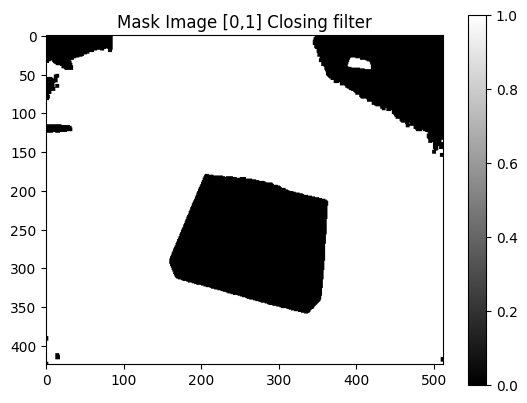

In [261]:
# Apply morphological filter to the mask image
mask_morphological_filtered_floor_0_1, filter_type = morphological_filter(mask_binary_floor_0_1, np.ones((5, 5), np.uint8), 'closing')
plt.imshow(mask_morphological_filtered_floor_0_1, cmap='gray')
plt.colorbar()  # Add a colorbar to the plot
plt.title(f'Mask Image [0,1] {filter_type}')
plt.show()

In [262]:
mask_final_floor = mask_morphological_filtered_floor_0_1.astype(bool)

In [263]:
# extract Not_floor Mask
def Not_floor_points(Point_Cloud, mask_final_floor):
    mask_None_zero_points = Point_Cloud[:, :, 2] != 0
    #Create mask for Not_floor points 
    mask_not_floor = mask_None_zero_points & ~mask_final_floor
    return mask_not_floor

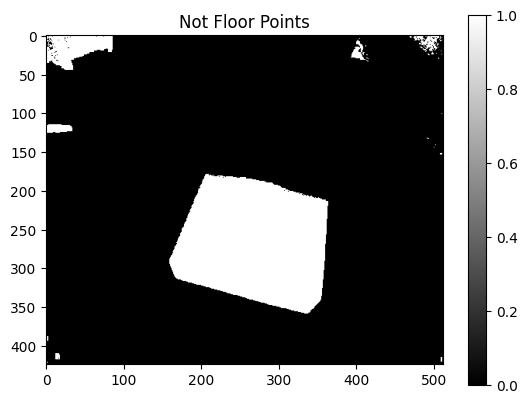

In [264]:
# Visualize Not_floor points
mask_not_floor = Not_floor_points(PC, mask_final_floor)
plt.imshow(mask_not_floor, cmap='gray')
plt.colorbar()  # Add a colorbar to the plot
plt.title('Not Floor Points')
plt.show()

In [265]:
def largest_connected_component(mask_not_floor):
    labeled_array, num_features = ndimage.label(mask_not_floor)
    
    # Find the largest connected component
    unique_labels, label_counts = np.unique(labeled_array, return_counts=True)
    
    # Exclude label 0, which represents the background
    label_counts = label_counts[1:]
    unique_labels = unique_labels[1:]

    # Find Largest_Component Label
    largest_component_label = unique_labels[np.argmax(label_counts)]
    
    # Create a mask for the largest component
    largest_component_mask = labeled_array == largest_component_label
    
    return largest_component_mask
    
    

In [266]:
largest_component_mask = largest_connected_component(mask_not_floor)

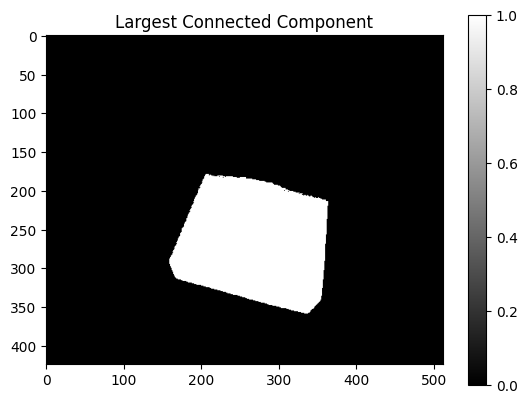

In [267]:
# Visualize largest connected component
plt.imshow(largest_component_mask, cmap='gray')
plt.colorbar()  # Add a colorbar to the plot
plt.title('Largest Connected Component')
plt.show()

In [268]:
# Improve via morphological operatiors
largest_component_mask = largest_component_mask.astype(np.uint8)
kernel = np.ones((5, 5), np.uint8)
closing_mask = cv2.morphologyEx(largest_component_mask, cv2.MORPH_CLOSE, kernel)
mask_box = closing_mask.astype(bool)
#opening_mask = cv2.morphologyEx(closing_mask, cv2.MORPH_OPEN, kernel)

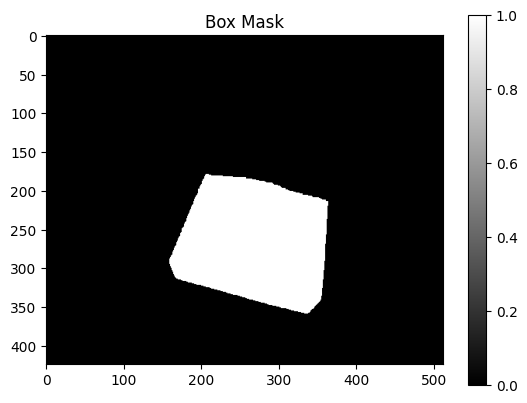

In [269]:
# Visualize Mask of the Box
plt.imshow(mask_box, cmap='gray')
plt.colorbar()  # Add a colorbar to the plot
plt.title('Box Mask')
plt.show()

box detection

In [270]:
def box_top_detection( point_cloud, threshold, max_iterations, mask_box ):
    print('****** box top detection function ******')
    box_top_eq = []
    mask_box_top = None
    
    box_top_eq , mask_box_top = ransac_box(point_cloud, threshold, max_iterations, mask_box)
    print('****** RANSAC algorithm finished! ******')
    
    return box_top_eq, mask_box_top

def ransac_box(point_cloud, threshold, max_iterations, mask_box):
    print('****** RANSAC algorithm get started ... ******')

    best_eq = []
    best_mask_box_top = None
    best_num_inliers = 0

    print('****** extract remained points from point_cloud ******')
    #extract box points from point_cloud
    remained_points = point_cloud[mask_box]

    print('****** start iterations ******')
    for iteration in range(max_iterations):
        
        # select 3 random points
        random_points = random.sample(remained_points.tolist(), 3)
        pt_samples = np.array(random_points)
        
        # Fit a plane model to the sampled points
        plane_eq = fit_plane(pt_samples)

        #inliers calculation
        num_inliers, mask_box_top = calculate_inliers_box(point_cloud, plane_eq, threshold, mask_box)

        # If this model has more inliers, update the best model
        if (num_inliers > best_num_inliers):
            best_num_inliers = num_inliers
            best_mask_box_top = mask_box_top
            best_eq = plane_eq

    return best_eq, best_mask_box_top

def fit_plane( pt_samples ):
    vecA = pt_samples[1, :] - pt_samples[0, :]
    vecB = pt_samples[2, :] - pt_samples[0, :]
    vecC = np.cross(vecA, vecB)
    vecC = vecC / np.linalg.norm(vecC) # Normalize vecC
    k = -np.sum(np.multiply(vecC, pt_samples[1, :]))
    # Ax+By+Cz+D = 0
    plane_eq = [vecC[0], vecC[1], vecC[2], k]
    return plane_eq

def calculate_inliers_box(point_cloud, plane_eq, threshold, mask_box):
    #Shape [i,j]
    distances = point_to_plane_distance(point_cloud, plane_eq )
    
    # Create a boolean mask to select points below the threshold
    # shape [i,j]
    mask_distance_threshold = distances <= threshold
    mask_box_top_points = mask_box & mask_distance_threshold


    inliers = point_cloud[mask_box_top_points]
    num_inliers = len(inliers)

    return num_inliers, mask_box_top_points

def point_to_plane_distance(point_cloud, plane_eq):
    A, B, C, D = plane_eq
    distances = np.abs((A * point_cloud[:, :, 0] + B * point_cloud[:, :, 1] + C * point_cloud[:, :, 2] + D) / np.sqrt(A**2 + B**2 + C**2))
    return distances

In [271]:
box_top_eq, mask_box_top = box_top_detection( point_cloud=PC, threshold=0.003, max_iterations=100, mask_box=mask_box )

****** box top detection function ******
****** RANSAC algorithm get started ... ******
****** extract remained points from point_cloud ******
****** start iterations ******
****** RANSAC algorithm finished! ******


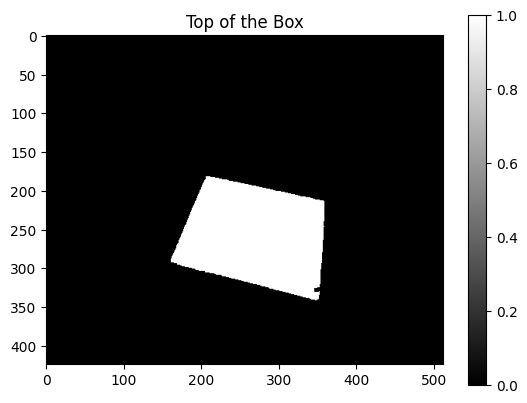

In [272]:
# Improve mask
mask_box_top_temp = mask_box_top.astype(np.uint8)
kernel = np.ones((5, 5), np.uint8)
mask_box_top_improved = cv2.morphologyEx(mask_box_top_temp, cv2.MORPH_CLOSE, kernel)
mask_box_top_final = mask_box_top_improved.astype(bool)

# visualize top of the box via mask_box_top
plt.imshow(mask_box_top_final, cmap='gray')
plt.colorbar()  # Add a colorbar to the plot
plt.title('Top of the Box')
plt.show()

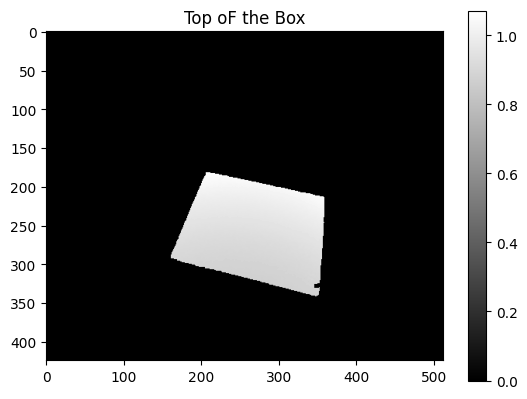

In [273]:
# visualize top of the box via mask_box_top
filtered_D = np.where(mask_box_top_final, D, 0)
plt.imshow(filtered_D, cmap='gray')
plt.colorbar()  # Add a colorbar to the plot
plt.title("Top oF the Box")
plt.show()

In [274]:
#Measure hight: find the distance between floor_plane and box_top_plane
floor_plane_eq = floor_eq
top_plane_eq = box_top_eq

def height_of_box(plane1, plane2):
    A1, B1, C1, D1 = plane1
    A2, B2, C2, D2 = plane2

    # Calculate the distance between the planes
    distance = abs(D1 - D2) / math.sqrt(A1**2 + B1**2 + C1**2)

    return distance

height_box = height_of_box(floor_plane_eq, top_plane_eq)
print("Height of the Box:", height_box)

Height of the Box: 1.8251004204769776


In [275]:
floor_plane_eq = floor_eq
top_plane_eq = box_top_eq
mask_box = mask_box
mask_box_top_final = mask_box_top_final

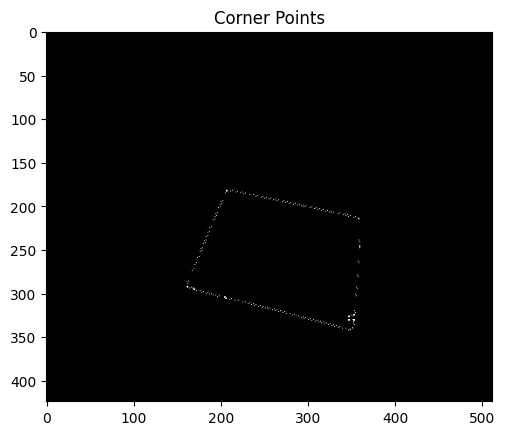

In [276]:
# Convert the binary mask to an 8-bit image (0 for background and 255 for object)
object_image = (mask_box_top_final * 255).astype(np.uint8)

# Apply Harris corner detection to the object image
corners = cv2.cornerHarris(object_image, blockSize=2, ksize=3, k=0.04)

# Threshold the corner response to get the corner mask
corner_mask = np.zeros_like(object_image)
#corner_mask[corners > 0.6 * corners.max()] = 1  # Adjust the threshold as needed
corner_mask[corners > 0.059 * corners.max()] = 1  # Adjust the threshold as needed


plt.imshow(corner_mask, cmap='gray')
plt.title('Corner Points')
plt.show()

In [277]:
def seperat_points_masks(corner_mask):
    # Find the coordinates of the True values in the mask
    true_coords = np.argwhere(corner_mask)
    
    # Create a list to store separate masks
    separate_masks = []

    # Loop through the True values and create a separate mask for each
    for coord in true_coords:
        # Create a binary mask of the same shape and initialize it with zeros
        separate_mask = np.zeros(corner_mask.shape, dtype=np.uint8)
        
        # Set the current coordinate to True in the separate mask
        separate_mask[coord[0], coord[1]] = 1
        
        separate_masks.append(separate_mask)
        
    return separate_masks

In [278]:
# Max point X
def max_point_x(separate_masks):
    max_x = -float('inf')
    max_point = None
    max_mask_x = None
    max_mask_x_index = -1

    for idx, mask in enumerate(separate_masks):
        mask = mask.astype(bool)
        point = PC[mask]
        point_x = point[0, 0]
        if point_x > max_x:
            max_x = point_x
            max_point = point
            max_mask_x = mask
            max_mask_x_index = idx
    return max_mask_x
        
#plt.imshow(max_mask_x, cmap='gray')
#plt.title('Max point X')
#plt.show()

In [279]:
# Max point Y
def max_point_y(separate_masks):
    max_y = -float('inf')
    max_point = None
    max_mask_y = None
    max_mask_y_index = -1
    
    for idx, mask in enumerate(separate_masks):
        mask = mask.astype(bool)
        point = PC[mask]
        point_y = point[0, 1]
        if point_y > max_y:
            max_y = point_y
            max_point = point
            max_mask_y = mask
            max_mask_y_index = idx
    return max_mask_y
        
#plt.imshow(max_mask_y, cmap='gray')
#plt.title('Max point Y')
#plt.show()

In [280]:
# Min point X
def min_point_x(separate_masks):
    min_x = float('inf')  # Initialize min_x with positive infinity
    min_point = None
    min_mask_x = None
    min_mask_x_index = -1
    
    for idx, mask in enumerate(separate_masks):
        mask = mask.astype(bool)
        point = PC[mask]
        point_x = point[0, 0]
        if point_x < min_x:
            min_x = point_x
            min_point = point
            min_mask_x = mask
            min_mask_x_index = idx
    return min_mask_x

#plt.imshow(min_mask_x, cmap='gray')
#plt.title('Min point X')
#plt.show()

In [281]:
# Min point Y
def min_point_y(separate_masks):
    min_y = float('inf')  # Initialize min_y with positive infinity
    min_point = None
    min_mask_y = None
    min_mask_y_index = -1
    
    for idx, mask in enumerate(separate_masks):
        mask = mask.astype(bool)
        point = PC[mask]
        point_y = point[0, 1]
        if point_y < min_y:
            min_y = point_y
            min_point = point
            min_mask_y = mask
            min_mask_y_index = idx
    return min_mask_y

#plt.imshow(min_mask_y, cmap='gray')
#plt.title('Min point Y')
#plt.show()

In [282]:
# Calculate the Euclidean distances
def cal_euclidean_distances(point_max_x, point_max_y, point_min_y, point_min_x):
    # Extract only the x and y coordinates
    point_max_x_2d = point_max_x[0, :2]
    point_max_y_2d = point_max_y[0, :2]
    point_min_y_2d = point_min_y[0, :2]
    point_min_x_2d = point_min_x[0, :2]

    # Calculate the Euclidean distances
    dis_min_x_max_y = np.linalg.norm(point_min_x_2d - point_max_y_2d)
    dis_max_y_max_x = np.linalg.norm(point_max_y_2d - point_max_x_2d)
    dis_min_y_max_x = np.linalg.norm(point_min_y_2d - point_max_x_2d)
    dis_min_y_min_x = np.linalg.norm(point_min_y_2d - point_min_x_2d)

    return dis_min_x_max_y, dis_max_y_max_x, dis_min_y_max_x, dis_min_y_min_x

In [283]:
# Calculate height of the box
height_box = height_of_box(floor_plane_eq, top_plane_eq)

# Calculate width and length of the box
separate_masks = seperat_points_masks(corner_mask)

max_mask_x = max_point_x(separate_masks)
max_mask_y = max_point_y(separate_masks)
min_mask_x = min_point_x(separate_masks)
min_mask_y = min_point_y(separate_masks)

point_max_x = PC[max_mask_x]
point_max_y = PC[max_mask_y]
point_min_x = PC[min_mask_x]
point_min_y = PC[min_mask_y]

#print(f'point_max_x: {point_max_x}')
#print(f'point_max_y: {point_max_y}')
#print(f'point_min_y: {point_min_y}')
#print(f'point_min_x: {point_min_x}')

dis_min_x_max_y, dis_max_y_max_x, dis_min_y_max_x, dis_min_y_min_x = cal_euclidean_distances(point_max_x, point_max_y, point_min_y, point_min_x)

# Print the distances
#print("Distance between point_min_x and point_max_y:", dis_min_x_max_y)
#print("Distance between point_min_y and point_max_x:", dis_min_y_max_x)
#print("Distance between point_max_y and point_max_x:", dis_max_y_max_x)
#print("Distance between point_min_y and point_min_x:", dis_min_y_min_x)

length_values = np.array([dis_min_x_max_y, dis_min_y_max_x])
length_box = np.mean(length_values)

width_values = np.array([dis_max_y_max_x, dis_min_y_min_x])
width_box = np.mean(width_values)

In [284]:
print("Height of the box : ", height_box)
print("Length of the box : ", length_box)
print("Width of the box  : ", width_box)

Height of the box :  1.8251004204769776
Length of the box :  0.4411898157321502
Width of the box  :  0.282147497526551


In [ ]:
# Box Detection - Discussion

In [290]:
mask_four_corners = max_mask_x | max_mask_y | min_mask_x | min_mask_y

In [291]:
def make_corners_more_visible(mask_four_corners):
    # Create a structuring element for dilation
    kernel = kernel = np.ones((5, 5), np.uint8)
    mask_four_corners = mask_four_corners.astype(np.uint8)
    
    # Apply dilation to make the surrounding points true
    expanded_mask_corners = cv2.dilate(mask_four_corners, kernel, iterations=1)
    
    return expanded_mask_corners


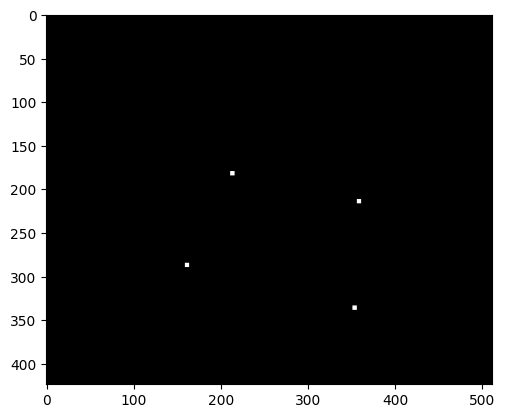

In [292]:
expanded_mask_corners = make_corners_more_visible(mask_four_corners)
plt.imshow(expanded_mask_corners, cmap='gray')
plt.show()

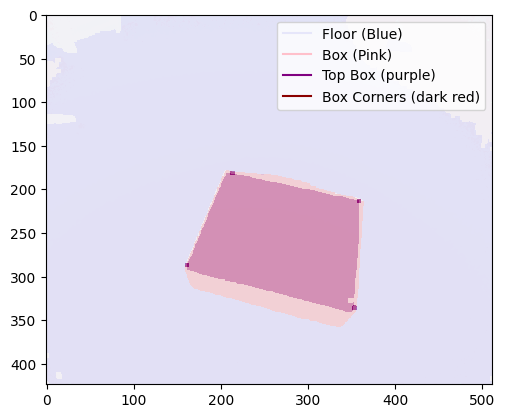

In [293]:
# Visualization of the Results 
import matplotlib.lines as mlines

# Create custom colormaps and norms for each mask
cmap_floor = plt.cm.colors.ListedColormap(['white', 'blue'])
cmap_box = plt.cm.colors.ListedColormap(['white', 'red'])
cmap_top = plt.cm.colors.ListedColormap(['white', 'purple'])
cmap_corner = plt.cm.colors.ListedColormap(['white', 'purple'])

bounds = [0, 0.5, 1]  # Define color boundaries

norm_floor = plt.cm.colors.BoundaryNorm(bounds, cmap_floor.N)
norm_box = plt.cm.colors.BoundaryNorm(bounds, cmap_box.N)
norm_top = plt.cm.colors.BoundaryNorm(bounds, cmap_top.N)
norm_corner = plt.cm.colors.BoundaryNorm(bounds, cmap_corner.N)


# Display the data with all three masks
plt.imshow(D, cmap='viridis')  # Display the data using a colormap (e.g., viridis)

# Overlay the floor mask in blue
floor_plot = plt.imshow(mask_final_floor, cmap=cmap_floor, norm=norm_floor, alpha=0.5)

# Overlay the box mask in pink
box_plot = plt.imshow(mask_box, cmap=cmap_box, norm=norm_box, alpha=0.5)

# Overlay the top_box mask in purple
top_plot = plt.imshow(mask_box_top_final, cmap=cmap_top, norm=norm_top, alpha=0.5)

# Overlay the corners mask in dark purple
corner_plot = plt.imshow(expanded_mask_corners, cmap=cmap_top, norm=norm_top, alpha=0.5)

#plt.colorbar()  # Add a colorbar
# Create custom legend entries using Line2D
legend_elements = [
    mlines.Line2D([], [], color='lavender', label='Floor (Blue)'),
    mlines.Line2D([], [], color='pink', label='Box (Pink)'),
    mlines.Line2D([], [], color='purple', label='Top Box (purple)'),
    mlines.Line2D([], [], color='darkred', label='Box Corners (dark red)'),
]

# Add a legend with custom legend entries
plt.legend(handles=legend_elements)

# Show the plot
plt.show()


In [1]:
def calculate_cost(hypotheses, data_point):
    # Calculate the cost for each hypothesis based on the data point
    costs = [calculate_individual_cost(h, data_point) for h in hypotheses]
    return costs

def reorder_and_retain_top_hypotheses(hypotheses, costs, f_i):
    # Combine hypotheses and costs into a list of tuples
    hypothesis_costs = list(zip(hypotheses, costs))

    # Sort the list based on costs in ascending order
    hypothesis_costs.sort(key=lambda x: x[1])

    # Retain the top f_i hypotheses
    top_hypotheses = [hypothesis for hypothesis, _ in hypothesis_costs[:f_i]]

    return top_hypotheses

In [2]:
def mlesac_ransac(data, iterations, epsilon, gamma):
    best_model = None
    best_cost = float('inf')

    for _ in range(iterations):
        # Randomly sample data points to form a hypothesis/model
        hypothesis = random_sample(data)

        # Evaluate the cost of the current hypothesis using MLESAC scoring
        current_cost = calculate_cost(data, epsilon, gamma)

        # Update the best model if the current one is better
        if current_cost < best_cost:
            best_cost = current_cost
            best_model = hypothesis

    return best_model

In [4]:
data = generate_data()  # Replace with your data generation or input logic
iterations = 100  # Choose the number of iterations
epsilon = 0.1  # Choose the error threshold
gamma = 1.0  # Choose the constant error

best_model = mlesac_ransac(data, iterations, epsilon, gamma)
print("Best Model:", best_model)

NameError: name 'generate_data' is not defined